# Using ART to defend against backdoor attacks in DNNs through CCA-UD
---

## 0. Acknowledgements
This implementation is possible thanks to Wei Guo, Benedetta Tondi and Mauro Barni's paper "Universal Detection of Backdoor Attacks via Density-based Clustering and Centroids Analysis".

## 1. Backdoor attacks
A backdoor attack is a sub technique of a dataset poisoning attack. This technique aims at degrading the integrity of a machine learning model by poisoning a portion of the training dataset before training by adding a specific input modification only known to the attacker. This modification is called the "triggering signal". Once the model is trained, it will have learned a hidden malevolent behaviour. This behaviour can be triggered during prediction by using inputs that contain the triggering signal. However, as the test dataset remains unchanged, the _backdoored model_ works as normally expected. Therefore, the vulnerability goes unnoticed to the defenders.

## 2. Detecting backdoor attacks in DNNs with density-based clustering and centroid analysis
[Guo, et al. (2021)](https://arxiv.org/abs/2301.04554) proposed a universal detector which uses density-based clustering and centroid analysis to detect backdoor attacks in deep neural networks (CCA-UD). The basics of the algorithm are described in the following sections. For a more in depth understanding of CCA-UD, the original paper is recommended.

### 2.1. I/O CCA-UD

The following I/O descriptions do not correspond to a single function's parameters and/or return values, but serve as a general overview of what the algorithm uses and returns in a usage scenario.

### Inputs
| Input                                                       | Description                                                                                                    |
|-------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------|
| Poisoned training set features (`x_train`)                  | Dataset of independent variables used to train the classifier                                                  |
| Poisoned training set labels (`y_train`)                    | Labels used to train the classifier                                                                            |
| Benign indices (`benign_indices`)                           | Indices of `x_train` that are definitely benign samples                                                        |
| Final feature layer (`final_feature_layer`)                 | Name of the final layer that builds the feature representation. It is used to slice the DNN into two submodels |
| Misclassification threshold (`misclassification_threshold`) | Percentage of mis classifications needed to consider a cluster as poisoned                                     |
| True poison labels (`is_clean`)                             | True poison labels used to evaluate the defence's performance agains the detected poisoned points              |

### Outputs
| Ouptut                | Description                                                                                                     |
|-----------------------|-----------------------------------------------------------------------------------------------------------------|
| Poisoning verdict     | List of `x_train` with 1/0 labels; 1 means the data point is clean, whereas 0 means it was detected as poisoned |
| Report                | Dictionary with report details on the dataset's performance                                                     |
| Confusion matrix JSON | JSON-like object with the detection performance results, given the true poisoned labels                         |


### 2.2. Steps of CCA-UD
The algorithm's two main steps will be briefly explained below:
1. **Dimensionality reduction and feature clustering**: first, the feature representations of the dataset are obtained using a slice of the DNN. Then, the dimensions of these representations are reduced using UMAP. Finally, the reduced feature representations are clustered using a noise sensitive algorithm, like DBSCAN. It is worth noting that the dimensionality reduction is only used for clustering purposes. Following steps use the full feature representations.
2. **Poisoned cluster detection (PCD)**: for each cluster found, the centroid is calculated. This should roughly equate to the average feature representation for each cluster. Afterward, the centroids are calculated for the benign subset of the dataset. This will be called the _benign centroids_. Using the benign centroids, for each class, for each cluster the deviation is calculated as the difference between the benign class' centroid and the cluster's centroid. Finally, the deviations are added to the benign feature representations belonging to all other classes and are classified using the second slice of the DNN classifier. If this deviation causes significant misclassification (surpassing a misclassification threshold), the cluster to which it belongs is deemed poisoned.

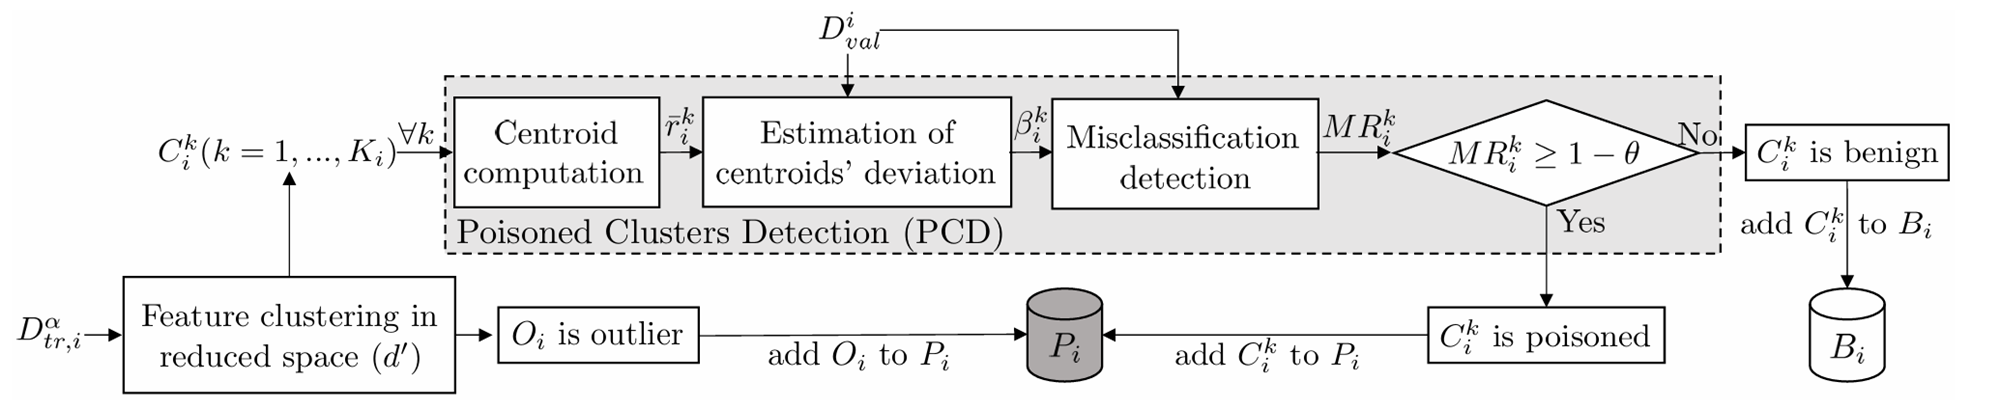
_<center>Workflow of the CCA-UD defence</center>_

### 2.3. Rationale behind CCA-UD
If a subset of the data is poisoned in a backdoor attack, a trigger signal must be encrusted in it. Moreover, the trigger signal must be significant enough to not be discarded as noise as it goes through the DNNs layers in order to be effective. Taking this into account, the algorithm uses this assumption to detect poisoned data. First, the noise-sensitive clustering algorithm distinguishes different data subsets, where poisoned samples are distinct enough to be classified separately. Second, the calculated centroid deviation roughly corresponds to the feature representation of the trigger signal. Supposing that the backdoor attack is effective, the feature representation of the trigger added to benign data feature representations should cause mislabelling.

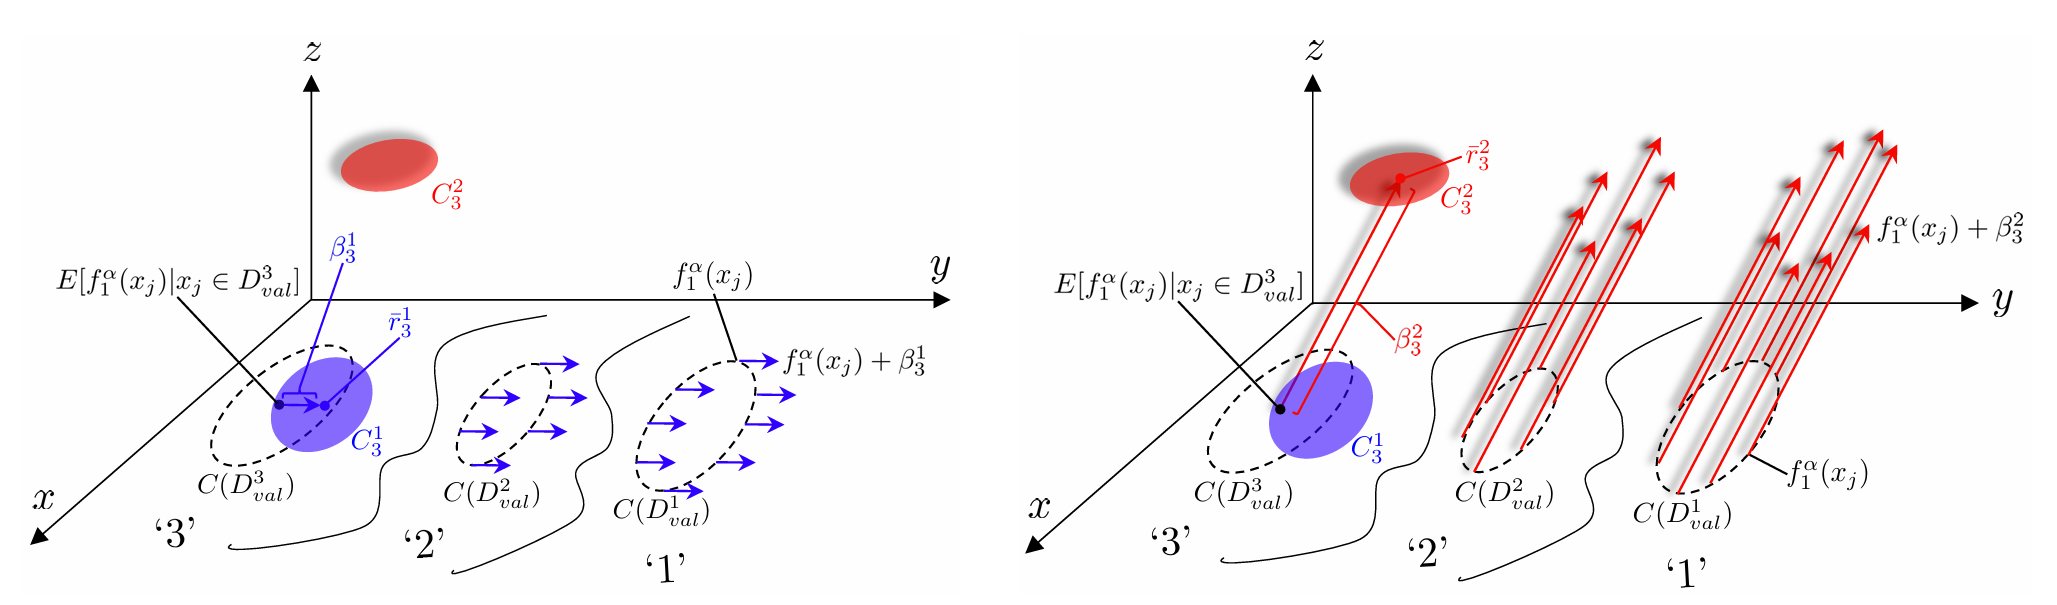
_<center>Simplified illustration of PCD (clean-label case). The scenario on the left has an insignificant centroid deviation, which is incapable of producing mislabels. The scenario on the right has a significant $z$ component capable of causing mis classification, which suggests it could be poisoned.<center>_


## 3. Example scenario: digit classifier
**Alice's goal (Defender)**: train a DNN classifier to classify handwritten digits from 0-9

**Eve's goal (Adversary)**: trick the classifier into thinking a handwritten digit is a 1 when it is by using a trigger signal.

**Poisoning technique**: clean-label poisoning. The adversary will create additional mislabelled training data containing the trigger signal.

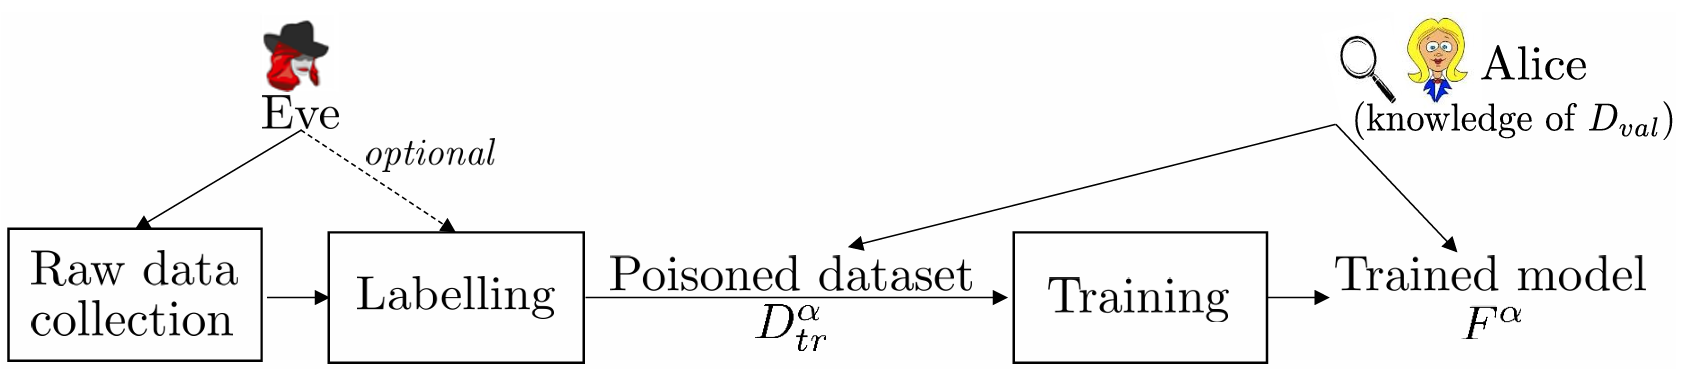
_<center>Threat model diagram</center>_


### 3.1 Setup
Loggers are created and libraries are imported.

In [136]:
# You can preinstall all prerequisites by uncommenting and running the following two commands:
# import sys
# !{sys.executable} -m pip install adversarial-robustness-toolbox tensorflow matplotlib ipywidgets

In [137]:
import logging

from art.performance_monitor import PerformanceTimer
from art.defences.detector.poison.clustering_centroid_analysis import ClusteringCentroidAnalysis

logger = logging.getLogger()
logger.setLevel(logging.WARNING)
handler = logging.StreamHandler()
formatter = logging.Formatter("[%(levelname)s] %(message)s")
handler.setFormatter(formatter)
logger.addHandler(handler)

In [138]:
from __future__ import absolute_import, division, print_function, unicode_literals
import json
import os
import pprint
import sys
import warnings

import numpy as np

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from art.estimators.classification import TensorFlowV2Classifier

# set module path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# ignore warning
warnings.filterwarnings('ignore')

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image
from art.defences.detector.poison import ActivationDefence
from art.utils import load_mnist, preprocess

### 3.2. Data loading
The MNIST dataset will be used for this example. The reader can select a random subset if desired.
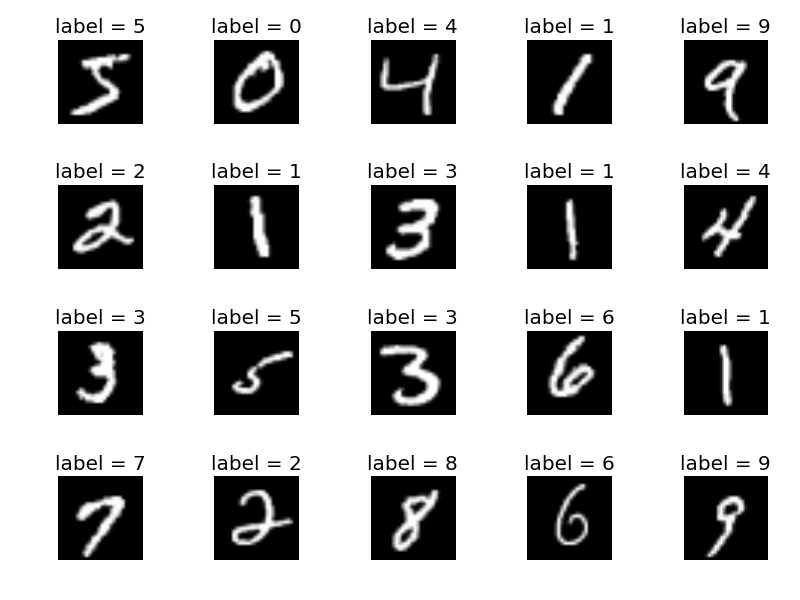

In [139]:
(x_raw_train, y_raw_train), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Random Selection:
n_train = np.shape(x_raw_train)[0]
num_selection = 30_000
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw_train = x_raw_train[random_selection_indices]
y_raw_train = y_raw_train[random_selection_indices]

# Poisoning sub technique
BACKDOOR_TYPE = "pattern" # one of ['pattern', 'pixel', 'image']

In [140]:
print(x_raw_train.shape)
print(x_raw_train.shape)

(30000, 28, 28)
(30000, 28, 28)


In [141]:
max_val = np.max(x_raw_train)
def add_modification(x):
    """
    Function to add the malicious modification according to the provided technique
    """
    if BACKDOOR_TYPE == 'pattern':
        return add_pattern_bd(x, pixel_value=max_val)
    elif BACKDOOR_TYPE == 'pixel':
        return add_single_bd(x, pixel_value=max_val) 
    elif BACKDOOR_TYPE == 'image':
        return insert_image(x, backdoor_path='../utils/data/backdoors/alert.png', size=(10, 10))
    else:
        raise("Unknown backdoor type")

In [142]:
def poison_dataset(x_clean, y_clean, percent_poison, poison_func):
    """
    Poisoning function. Takes clean samples, separated by features and labels, a percentage of desired poisoning and a poisoning function
    Returns the poisoned samples, separated by features and labels, poisoned via the poison function.
    """
    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))
    
    sources=np.arange(10)
    targets=(np.arange(10) + 1) % 10
    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(y_clean == tgt))
        num_poison = round((percent_poison * n_points_in_tgt) / (1 - percent_poison))
        src_imgs = x_clean[y_clean == src]

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, num_poison)

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
        backdoor_attack = PoisoningAttackBackdoor(poison_func)
        imgs_to_be_poisoned, poison_labels = backdoor_attack.poison(imgs_to_be_poisoned, y=np.ones(num_poison) * tgt)
        x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, poison_labels, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0

    return is_poison, x_poison, y_poison

### 3.3. Eve poisons the training dataset

In [143]:
# The vulnerable dataset is poisoned and preprocessed
poison_percentage = 0.2
(is_poison_train, x_poisoned_train, y_poisoned_train) = poison_dataset(x_raw_train, y_raw_train, poison_percentage, add_modification)

x_poisoned_train = x_poisoned_train.astype(np.float32) / 255.0
y_poisoned_train = y_poisoned_train.astype('int32')
is_poison_train = is_poison_train.astype('int32')

# Add channel axis:
x_poisoned_train = np.expand_dims(x_poisoned_train, axis=3)

# Shuffle training data
n_train = np.shape(y_poisoned_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_poisoned_train = x_poisoned_train[shuffled_indices]
y_poisoned_train = y_poisoned_train[shuffled_indices]
is_poison_train = is_poison_train[shuffled_indices]


In [144]:
# The vulnerable dataset is poisoned and preprocessed
(is_poison_test, x_poisoned_test, y_poisoned_test) = poison_dataset(x_raw_test, y_raw_test, poison_percentage, add_modification)

x_poisoned_test = x_poisoned_test.astype(np.float32) / 255.0
y_poisoned_test = y_poisoned_test.astype('int32')
is_poison_test = is_poison_test.astype('int32')

# Add channel axis:
x_poisoned_test = np.expand_dims(x_poisoned_test, axis=3)

### 3.3. Alice trains the DNN

Starting performance measurement for: DNN Fitting
Epoch 1/8
1172/1172 [==============================] - 7s 6ms/step - loss: 0.4551 - accuracy: 0.8560
Epoch 2/8
1172/1172 [==============================] - 7s 6ms/step - loss: 0.1667 - accuracy: 0.9501
Epoch 3/8
1172/1172 [==============================] - 8s 7ms/step - loss: 0.1240 - accuracy: 0.9618
Epoch 4/8
1172/1172 [==============================] - 12s 10ms/step - loss: 0.0996 - accuracy: 0.9690
Epoch 5/8
1172/1172 [==============================] - 8s 7ms/step - loss: 0.0860 - accuracy: 0.9727
Epoch 6/8
1172/1172 [==============================] - 7s 6ms/step - loss: 0.0734 - accuracy: 0.9770
Epoch 7/8
1172/1172 [==============================] - 9s 7ms/step - loss: 0.0642 - accuracy: 0.9805
Epoch 8/8
1172/1172 [==============================] - 13s 11ms/step - loss: 0.0578 - accuracy: 0.9812

Performance Summary for DNN Fitting:
Execution Time: 71.30 seconds
duration_seconds: 71.19
cpu_percent_mean: 140.76
cpu_percent_max: 158.

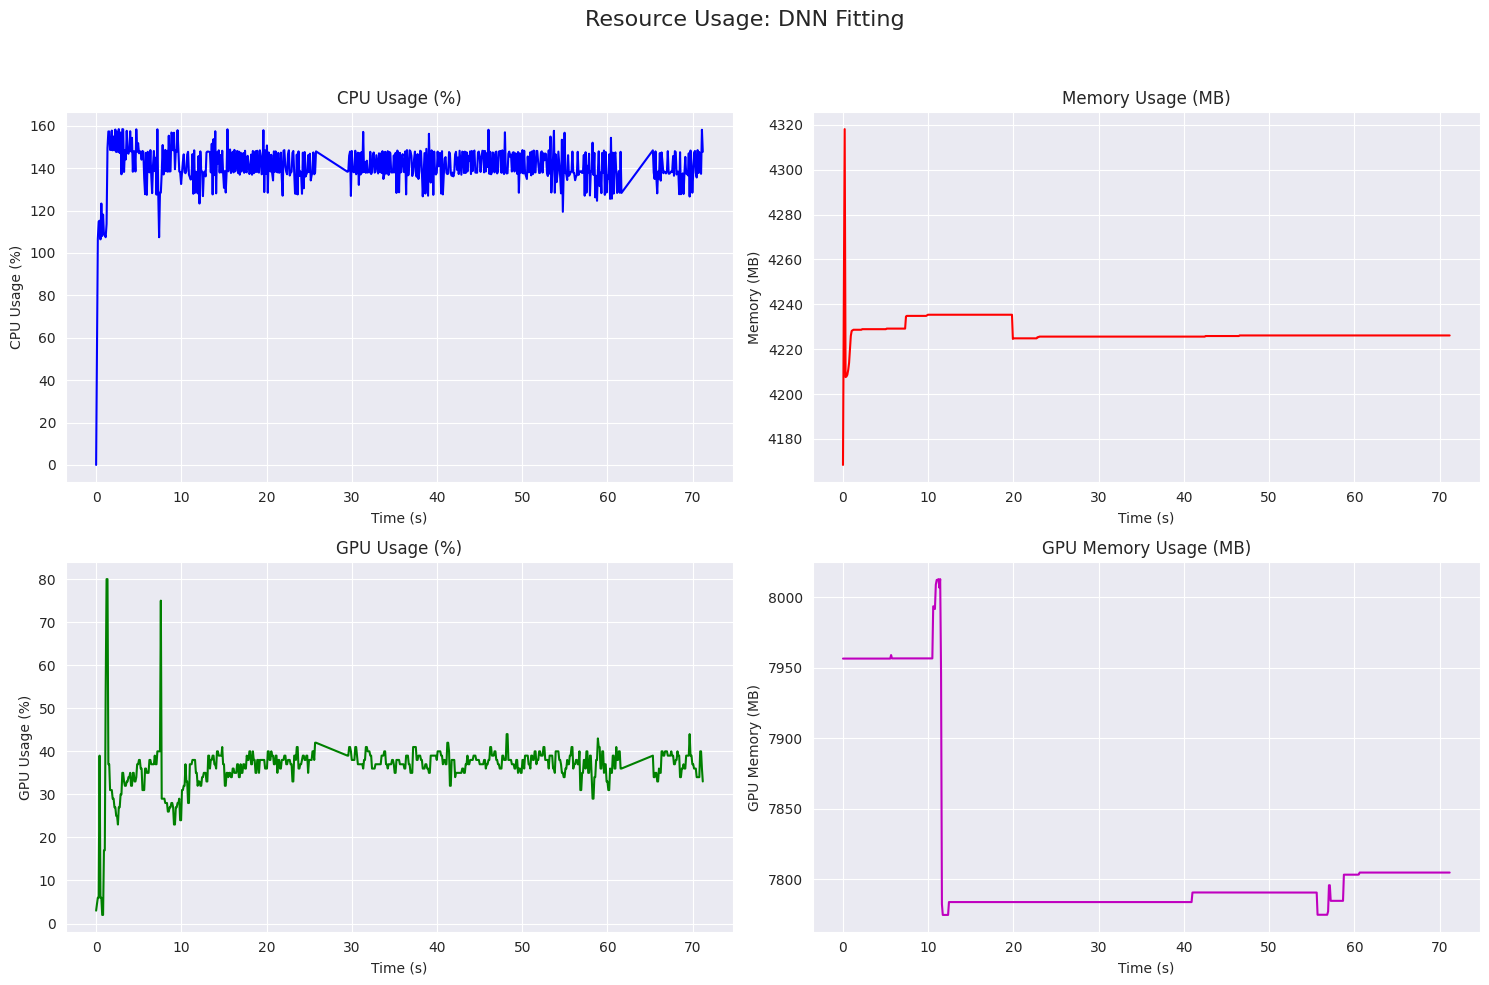

Model: "poisoned_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (Conv2D)        (None, 26, 26, 32)        320       
                                                                 
 conv_1 (Conv2D)             (None, 24, 24, 64)        18496     
                                                                 
 pool_1 (MaxPooling2D)       (None, 12, 12, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               1179776   
                                                                 
 dropout_2 (Dropout)         (None, 128)            

In [145]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

model = Sequential(name="poisoned_model", layers=[
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1), name="input_layer"),
    Conv2D(64, (3, 3), activation='relu', name="conv_1"),
    MaxPooling2D(pool_size=(2, 2), name="pool_1"),
    Dropout(0.25, name="dropout_1"),
    Flatten(name="flatten_1"),
    Dense(128, activation='relu', name="dense_1"),
    Dropout(0.5, name="dropout_2"),
    Dense(10, activation='softmax', name="output_layer")
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

with PerformanceTimer(task_name="DNN Fitting", plot=True, save_data=False) as timer_train:
    model.fit(x_poisoned_train, y_poisoned_train, epochs=8, verbose=True)

model.summary()

In [146]:
# The classifier is wrapped with an ART-friendly TF wrapper.
classifier = TensorFlowV2Classifier(
    model=model,
    loss_object=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    # Adjust this based on your model's output layer
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # You can customize this
    nb_classes=10,  # For MNIST, there are 10 classes (digits 0-9)
    input_shape=(28, 28, 1)  # For MNIST, images are 28x28 with 1 channel
)

### 3.4. Alice tests the classifier
#### 3.4.1. Evaluation on clean samples

In [147]:
clean_x_test = x_poisoned_test[np.where(is_poison_test == 0)]
clean_y_test = y_poisoned_test[np.where(is_poison_test == 0)]
y_pred = np.argmax(classifier.predict(clean_x_test), axis=1)
y_true = clean_y_test

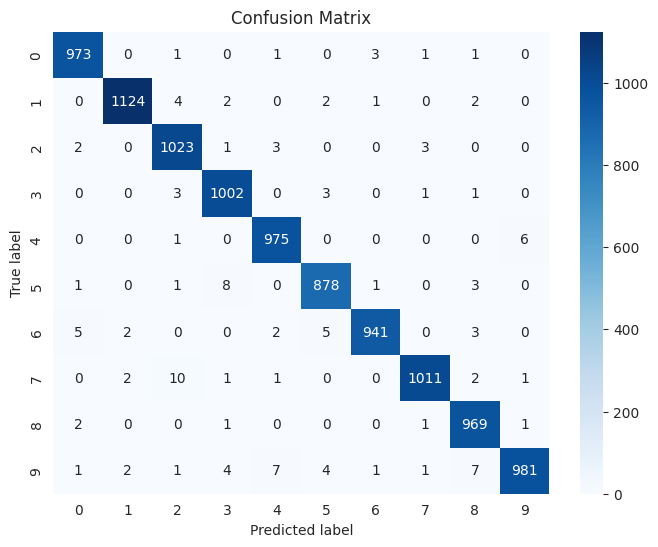

              precision    recall  f1-score   support

           0     0.9888    0.9929    0.9908       980
           1     0.9947    0.9903    0.9925      1135
           2     0.9799    0.9913    0.9855      1032
           3     0.9833    0.9921    0.9877      1010
           4     0.9858    0.9929    0.9893       982
           5     0.9843    0.9843    0.9843       892
           6     0.9937    0.9823    0.9879       958
           7     0.9931    0.9835    0.9883      1028
           8     0.9808    0.9949    0.9878       974
           9     0.9919    0.9722    0.9820      1009

    accuracy                         0.9877     10000
   macro avg     0.9876    0.9877    0.9876     10000
weighted avg     0.9877    0.9877    0.9877     10000



In [148]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_true, y_pred, digits=4)
print(report)


The evaluation of the model on clean samples shows robust performance with very high precision, recall and F1 scores.

#### 3.4.2. Evaluation on poisoned samples

In [149]:
poison_x_test = x_poisoned_test[np.where(is_poison_test == 1)]
poison_y_test = y_poisoned_test[np.where(is_poison_test == 1)]
y_pred = np.argmax(classifier.predict(poison_x_test), axis=1)
y_true = poison_y_test

The following cell can be used to check how the model classifies the $i$-th sample of true class $c$.

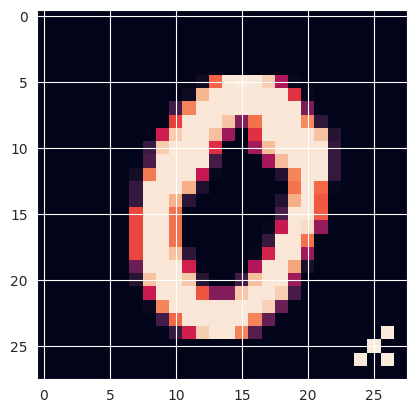

Prediction: 1
True Value: 1


In [150]:
c = 1
i = 6

c_idx = np.where(poison_y_test == c)[0][i]
plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()

print(f"Prediction: {y_pred[c_idx]}")
print(f"True Value: {y_true[c_idx]}")

It's clear that the backdoor is functional, ...

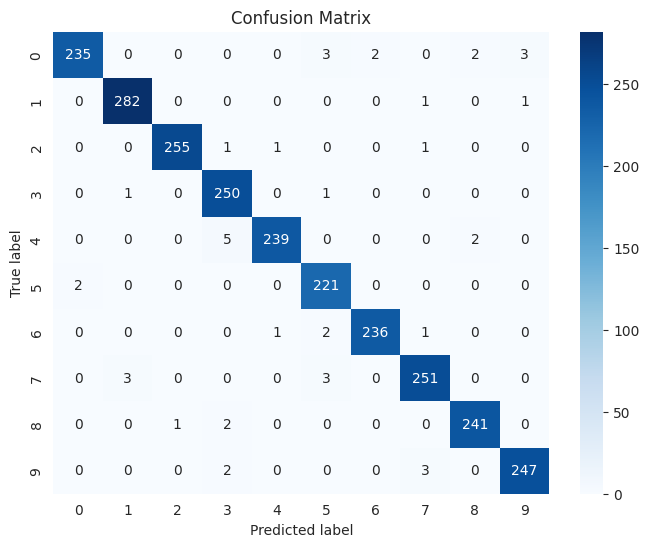

              precision    recall  f1-score   support

           0     0.9916    0.9592    0.9751       245
           1     0.9860    0.9930    0.9895       284
           2     0.9961    0.9884    0.9922       258
           3     0.9615    0.9921    0.9766       252
           4     0.9917    0.9715    0.9815       246
           5     0.9609    0.9910    0.9757       223
           6     0.9916    0.9833    0.9874       240
           7     0.9767    0.9767    0.9767       257
           8     0.9837    0.9877    0.9857       244
           9     0.9841    0.9802    0.9821       252

    accuracy                         0.9824      2501
   macro avg     0.9824    0.9823    0.9822      2501
weighted avg     0.9826    0.9824    0.9824      2501



In [151]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_true, y_pred, digits=4)
print(report)

... however, it can't be perceived through a performance evaluation. In fact, the model's performance remains intact! This demonstrates how the backdoor can go unnoticed from the most common (and naïve) model security check: degraded performance. Alice will think that her model is working properly, yet a backdoor is encrusted in it.

### 3.5. Poison detection using CCA-UD


#### 3.5.1. Benign sub set selection
It is expected from the defender that he/she can provide indices of the training data that correspond to benign data in order to calculate the benign centroids. In this scenario, 40% of the benign samples in the full dataset are given as benign sample to the algorithm.

In [152]:
sample_percentage = 0.3
benign_train_indices = np.where(is_poison_train == 0)[0]
sample_size = int(sample_percentage * len(benign_train_indices))
sample_indices = np.random.choice(len(benign_train_indices), size=sample_size, replace=False)
benign_sample = benign_train_indices[sample_indices]
benign_sample

array([18297, 29905, 21623, ..., 11406,  8187, 17937])

#### 3.5.2. Poison detector execution
CCA-UD is run with the specified parameters. The misclassification threshold represents the minimum mis classification percentage required in a cluster to consider it poisoned. Note that the definition here and in ART's CCA-UD implementation differs from that of the original paper. This was done after studying how it behaved in these scenarios.

Starting performance measurement for: Poison Detection
1/1 [==============================] - 0s 22ms/step

Performance Summary for Poison Detection:
Execution Time: 38.39 seconds
duration_seconds: 38.36
cpu_percent_mean: 215.43
cpu_percent_max: 898.10
memory_mb_mean: 4374.99
memory_mb_max: 4611.86
gpu_percent_mean: 27.22
gpu_percent_max: 94.00
gpu_memory_mb_mean: 7801.05
gpu_memory_mb_max: 7820.21


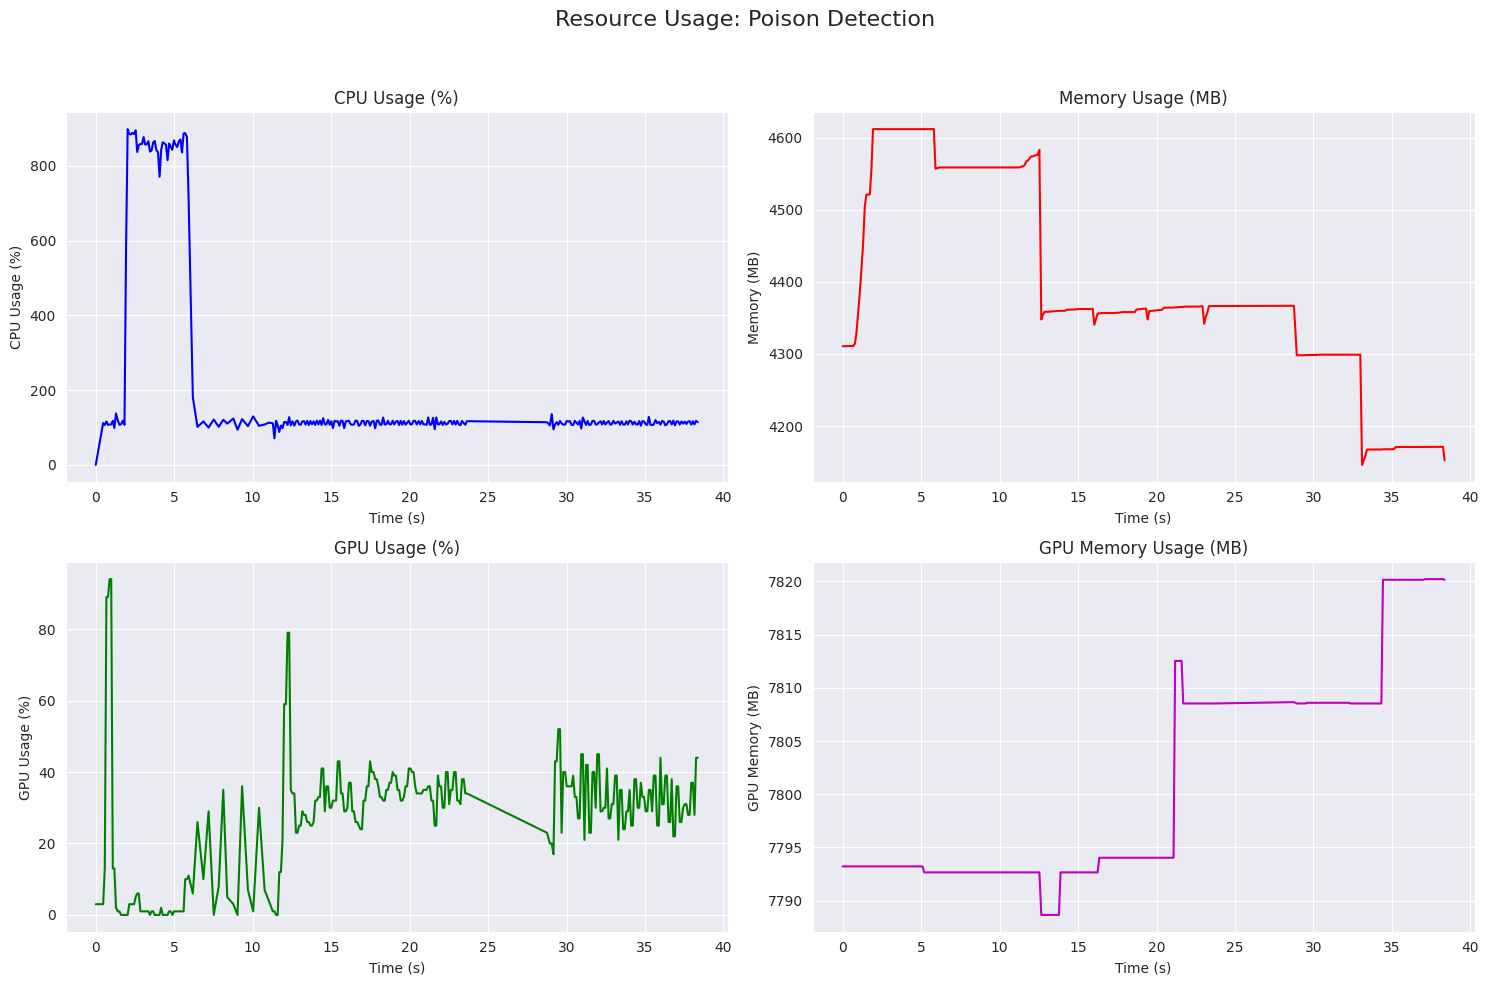

In [153]:
from art.performance_monitor import PerformanceTimer

defence = ClusteringCentroidAnalysis(classifier, x_poisoned_train, y_poisoned_train, benign_sample, "dense_1", misclassification_threshold=0.05)

with PerformanceTimer(task_name="Poison Detection", plot=True, save_data=False) as timer_ccaud:
    report, is_clean_lst = defence.detect_poison()


#### 3.5.3. Detector's performance evaluation

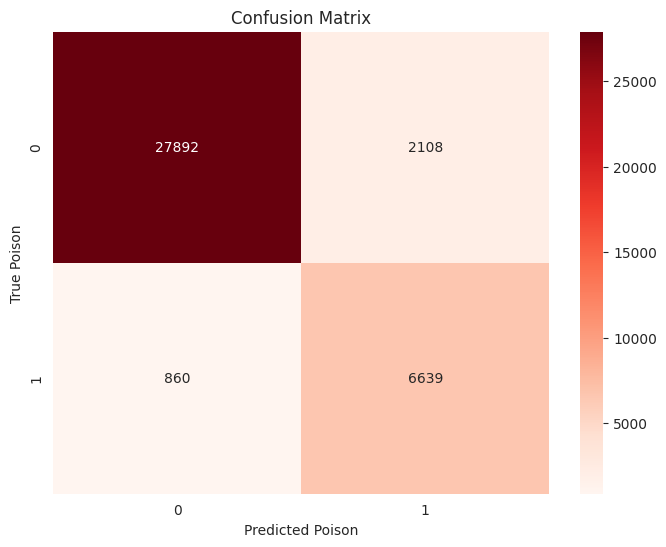

              precision    recall  f1-score   support

           0     0.9701    0.9297    0.9495     30000
           1     0.7590    0.8853    0.8173      7499

    accuracy                         0.9209     37499
   macro avg     0.8645    0.9075    0.8834     37499
weighted avg     0.9279    0.9209    0.9231     37499

AUC: 0.9075


In [163]:
from sklearn.metrics import confusion_matrix, roc_auc_score

is_poisoned_lst = 1 - is_clean_lst.astype('int32')
poison_confusion_matrix = confusion_matrix(is_poison_train, is_poisoned_lst)
auc = roc_auc_score(is_poison_train, is_poisoned_lst)
plt.figure(figsize=(8, 6))

sns.heatmap(poison_confusion_matrix, annot=True, fmt="d", cmap="Reds")
plt.xlabel("Predicted Poison")
plt.ylabel("True Poison")
plt.title("Confusion Matrix")
plt.show()

sklearn_report = classification_report(is_poison_train, is_poisoned_lst, digits=4)
print(sklearn_report)
print(f"AUC: {auc:.4f}")

CCA-UD shows a robust performance, with ~0.92 for precision, recall and the F1 score. Moreover, the AUC score is 0.9075.

In [162]:
performance_summary = timer_ccaud.get_summary()
print("\nDetailed Performance Metrics:")
for metric, value in performance_summary.items():
    print(f"  {metric}: {value:.2f}")


Detailed Performance Metrics:
  duration_seconds: 38.36
  cpu_percent_mean: 215.43
  cpu_percent_max: 898.10
  memory_mb_mean: 4374.99
  memory_mb_max: 4611.86
  gpu_percent_mean: 27.22
  gpu_percent_max: 94.00
  gpu_memory_mb_mean: 7801.05
  gpu_memory_mb_max: 7820.21


Furthermore, the poison detection took no longer than the DNN fitting, using a high percentage of the available GPU through TensorFlow.

#### 3.5.4. Results' analysis
ART's CCA-UD implementation also includes a report with information related to the algorithm's inner workings. This includes: cluster labels for the provided dataset, centroid and deviation $L_2$ norms, target class, number of elements and mis classification rate for each found cluster.

In [156]:
pprint.pprint(report)

{'cluster_data': {0: {'centroid_l2': 19.45309,
                      'class': 0,
                      'deviation_l2': 30.103567,
                      'misclassification_rate': 0.033006134969325154,
                      'size': 698},
                  1: {'centroid_l2': 27.699108,
                      'class': 0,
                      'deviation_l2': 2.6903417,
                      'misclassification_rate': 0.000245398773006135,
                      'size': 1556},
                  2: {'centroid_l2': 21.941496,
                      'class': 0,
                      'deviation_l2': 4.035923,
                      'misclassification_rate': 0.0,
                      'size': 1006},
                  3: {'centroid_l2': 25.300592,
                      'class': 0,
                      'deviation_l2': 8.40155,
                      'misclassification_rate': 0.000245398773006135,
                      'size': 25},
                  4: {'centroid_l2': 33.717743,
                      'c

In [157]:
# Get clusters with feature representations
clusters_with_features = report["cluster_labels"]

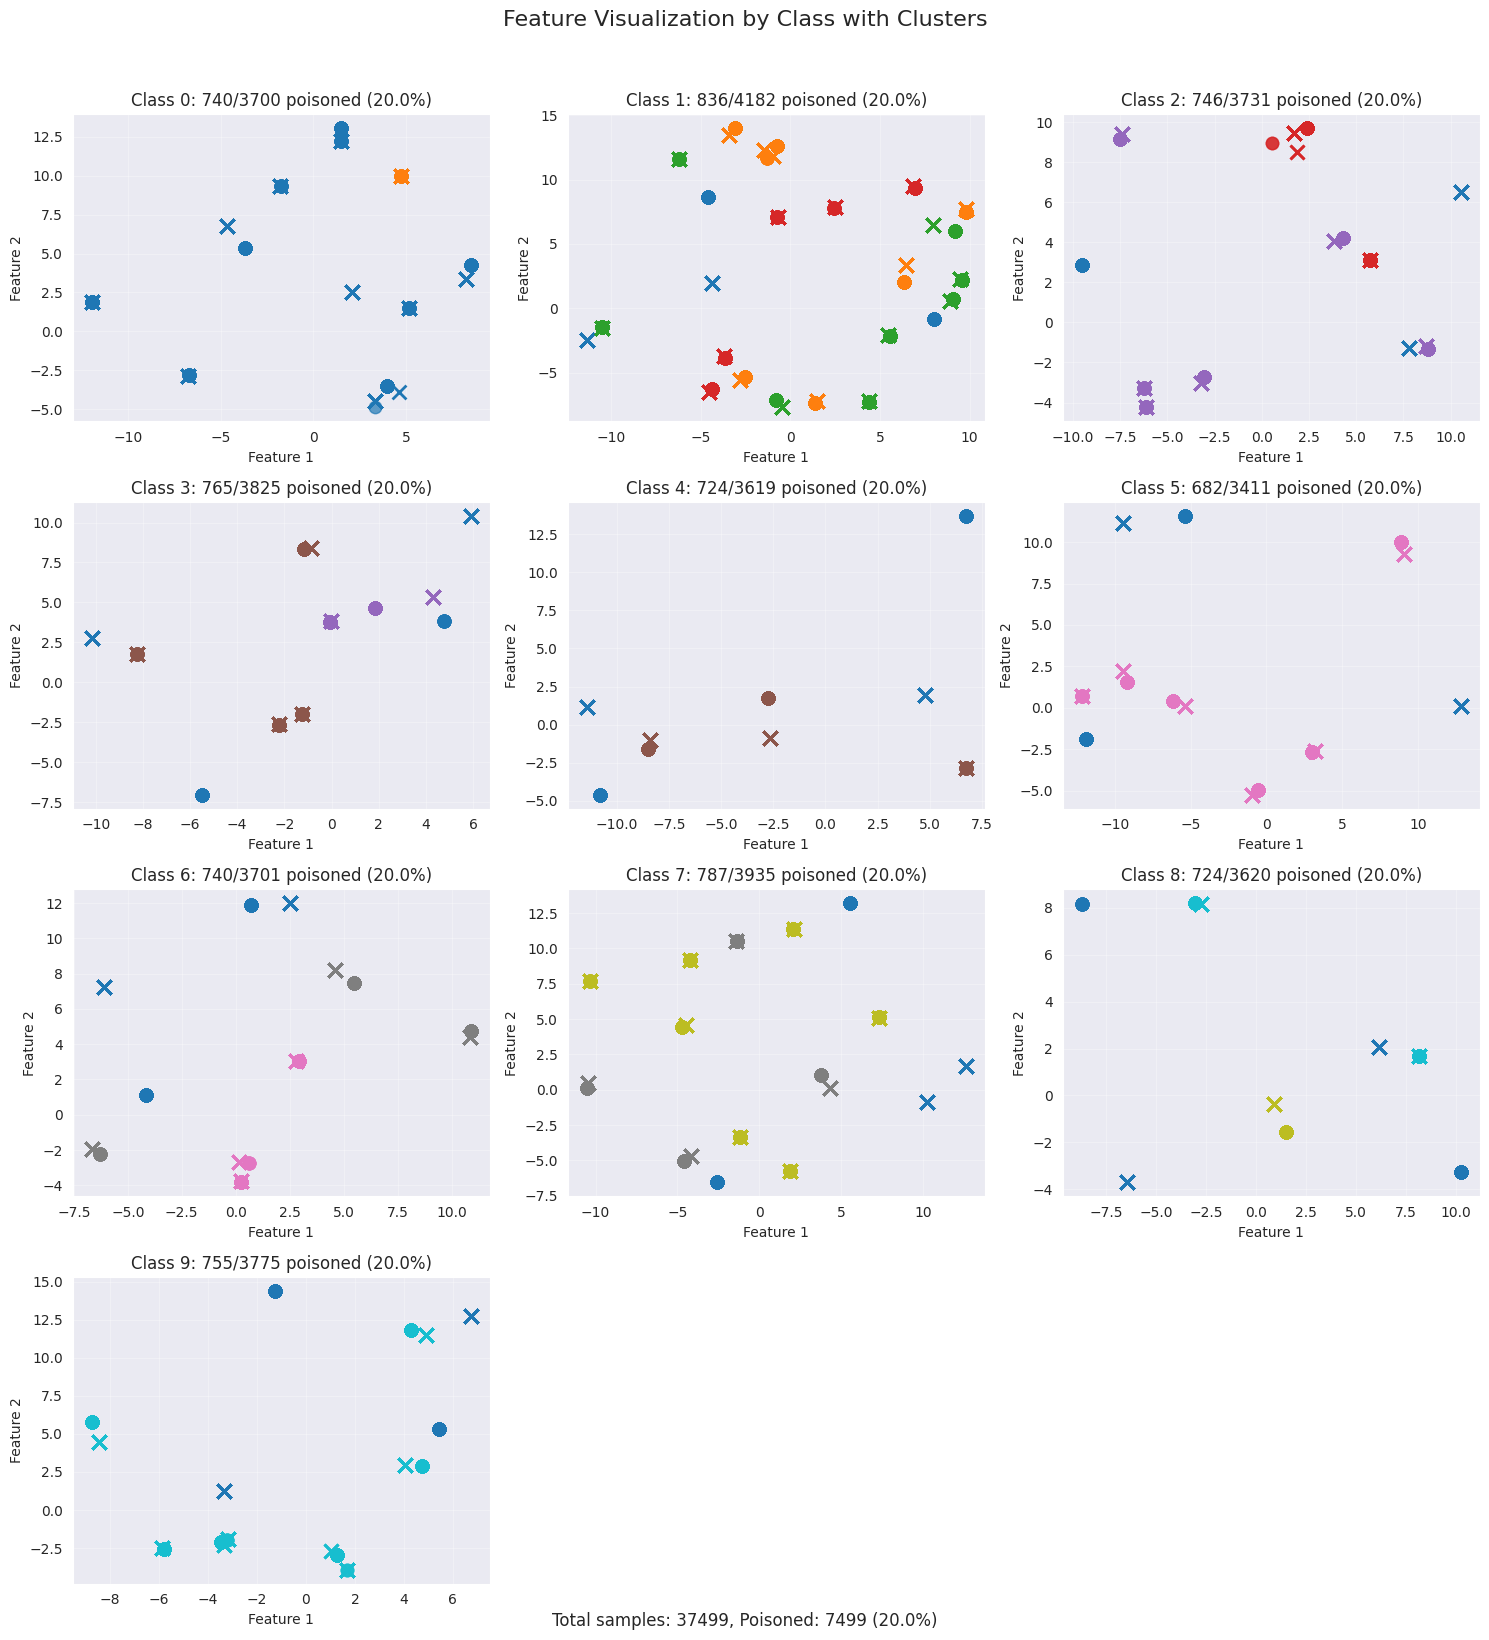

<Figure size 800x200 with 0 Axes>

In [158]:
import matplotlib.pyplot as plt
import numpy as np


def visualize_clusters_by_class(clusters_with_features, is_poison, class_labels):
    """
    Visualize clusters with poisoned samples highlighted, with a separate plot for each class.

    Args:
        clusters_with_features: Output from get_clusters() method
                              - First n-1 columns are feature representations
                              - Last column contains cluster labels
        is_poison: Boolean array indicating which samples are poisoned
        class_labels: Array with class labels for each sample
    """
    # Extract features (first 2 columns) and cluster labels (last column)
    features = clusters_with_features[:, :2]  # Assuming 2D features
    cluster_labels = clusters_with_features[:, -1].astype(int)

    # Get unique classes and clusters
    unique_classes = np.unique(class_labels)
    unique_clusters = np.unique(cluster_labels)

    # Create a color map for clusters
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))

    # Calculate figure size based on number of classes
    n_cols = min(3, len(unique_classes))  # Max 3 columns
    n_rows = int(np.ceil(len(unique_classes) / n_cols))
    fig_width = n_cols * 5  # 5 inches per column
    fig_height = n_rows * 4  # 4 inches per row

    # Create a figure with subplots - one for each class
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))

    # Flatten axes for easier indexing
    if len(unique_classes) > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    # Create a custom legend for sample types (poisoned vs benign)
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
               markersize=10, label='Benign Samples'),
        Line2D([0], [0], marker='x', color='k',
               markersize=10, linewidth=2, label='Poisoned Samples')
    ]

    # Add elements for cluster colors
    for i, cluster in enumerate(unique_clusters):
        legend_elements.append(
            Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i],
                   markersize=10, label=f'Cluster {cluster}')
        )

    # Create legend in a separate figure
    fig_legend = plt.figure(figsize=(8, 2))
    fig_legend.legend(handles=legend_elements, loc='center', ncol=min(5, len(legend_elements)),
                      fontsize=12, frameon=True)
    fig_legend.tight_layout()

    # Plot each class in its own subplot
    for i, class_label in enumerate(unique_classes):
        ax = axes[i]

        # Get indices for this class
        class_indices = np.where(class_labels == class_label)[0]

        # Class statistics
        class_total = len(class_indices)
        class_poisoned = np.sum(is_poison[class_indices])

        # Skip if there are no samples for this class
        if class_total == 0:
            ax.text(0.5, 0.5, f"No samples for class {class_label}",
                    ha='center', va='center', transform=ax.transAxes)
            continue

        # For each cluster, plot samples belonging to this class
        for j, cluster in enumerate(unique_clusters):
            # Find samples that belong to both this class and this cluster
            cluster_class_indices = class_indices[cluster_labels[class_indices] == cluster]

            if len(cluster_class_indices) == 0:
                continue

            # Split into benign and poisoned
            benign_indices = cluster_class_indices[~is_poison[cluster_class_indices]]
            poison_indices = cluster_class_indices[is_poison[cluster_class_indices]]

            # Plot benign samples as circles
            if len(benign_indices) > 0:
                ax.scatter(
                    features[benign_indices, 0],
                    features[benign_indices, 1],
                    c=[colors[j]],
                    marker='o',
                    s=80,
                    alpha=0.7
                )

            # Plot poisoned samples as x's with the same color but darker outline
            if len(poison_indices) > 0:
                ax.scatter(
                    features[poison_indices, 0],
                    features[poison_indices, 1],
                    c=[colors[j]],
                    marker='x',
                    s=100,
                    linewidths=2,
                    alpha=1.0
                )

        # Set title and labels for this subplot
        ax.set_title(
            f'Class {class_label}: {class_poisoned}/{class_total} poisoned ({class_poisoned / class_total:.1%})',
            fontsize=12)
        ax.set_xlabel('Feature 1', fontsize=10)
        ax.set_ylabel('Feature 2', fontsize=10)
        ax.grid(True, alpha=0.3)

    # Hide unused subplots
    for i in range(len(unique_classes), len(axes)):
        fig.delaxes(axes[i])

    # Add overall title
    fig.suptitle('Feature Visualization by Class with Clusters', fontsize=16, y=1.02)

    # Add overall statistics
    num_poison = np.sum(is_poison)
    num_total = len(is_poison)
    fig.text(0.5, 0.01, f'Total samples: {num_total}, Poisoned: {num_poison} ({num_poison / num_total:.1%})',
             ha='center', fontsize=12)

    # Adjust layout
    fig.tight_layout()

    return fig, fig_legend


# Example usage:
# Get clusters with feature representations from the defence object
# clusters_with_features = defence.get_clusters()

# Create visualization (assuming y_poisoned_train contains the class labels)
fig, fig_legend = visualize_clusters_by_class(clusters_with_features, is_poison_train, y_poisoned_train)

# Show the plots
plt.show()


It can be observed that class-wise, all classes are poisoned at a 20% rate, which coincides with the poisoning configuration.

Debug: Total poisoned samples in dataset: 7499 out of 37499
Debug: Cluster -1 has 399 poisoned samples out of 2332
Debug: In cluster -1, class 0 has 41 poisoned samples
Debug: In cluster -1, class 1 has 61 poisoned samples
Debug: In cluster -1, class 2 has 48 poisoned samples
Debug: In cluster -1, class 3 has 18 poisoned samples
Debug: In cluster -1, class 4 has 35 poisoned samples
Debug: In cluster -1, class 5 has 34 poisoned samples
Debug: In cluster -1, class 6 has 45 poisoned samples
Debug: In cluster -1, class 7 has 48 poisoned samples
Debug: In cluster -1, class 8 has 22 poisoned samples
Debug: In cluster -1, class 9 has 47 poisoned samples
Debug: Cluster 0 has 698 poisoned samples out of 698
Debug: In cluster 0, class 0 has 698 poisoned samples
Debug: Cluster 1 has 0 poisoned samples out of 1556
Debug: Cluster 2 has 1 poisoned samples out of 1006
Debug: In cluster 2, class 0 has 1 poisoned samples
Debug: Cluster 3 has 0 poisoned samples out of 25
Debug: Cluster 4 has 0 poisoned 

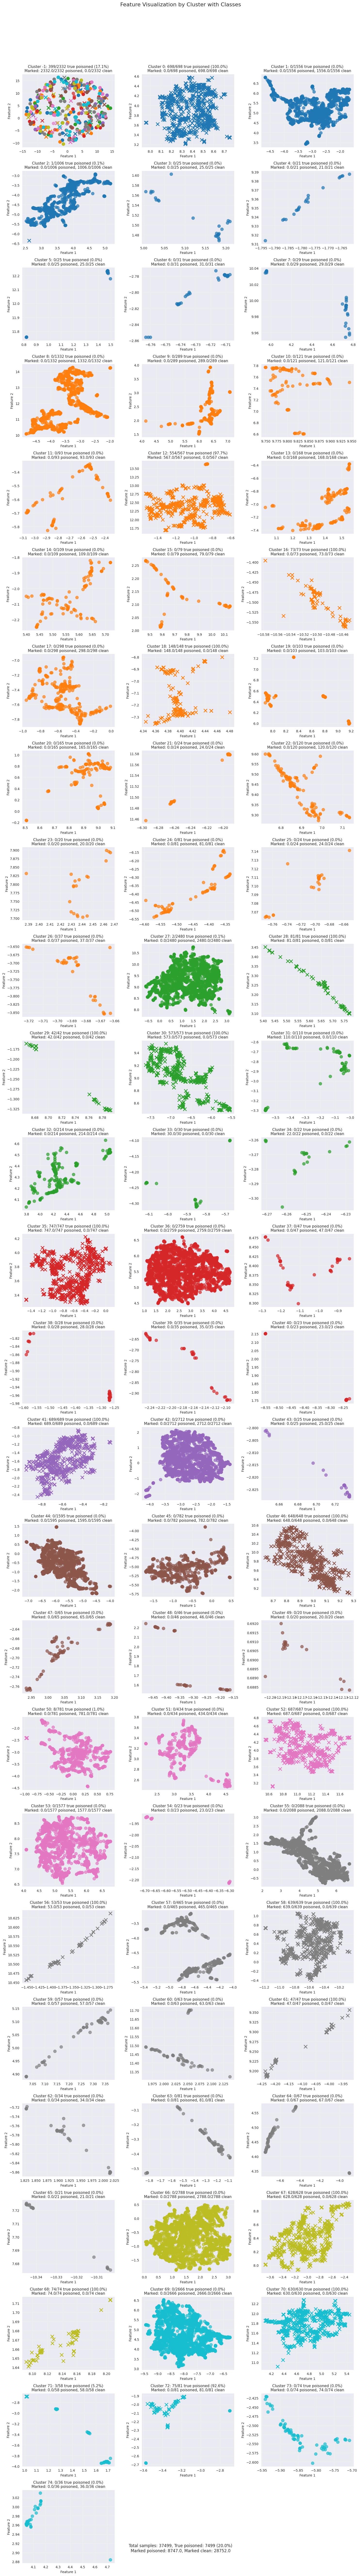

<Figure size 800x200 with 0 Axes>

In [159]:
import matplotlib.pyplot as plt
import numpy as np


def visualize_clusters_by_cluster(clusters_with_features, is_poison, class_labels, is_clean):
    """
    Visualize clusters with poisoned samples highlighted, with a separate plot for each cluster.
    Within each plot, colors represent different classes.

    Args:
        clusters_with_features: Output from get_clusters() method
                              - First n-1 columns are feature representations
                              - Last column contains cluster labels
        is_poison: Boolean array indicating which samples are poisoned (ground truth)
        class_labels: Array with class labels for each sample
        is_clean: Array of int values (1 or 0) indicating if a sample is classified as clean (1) or poisoned (0)
    """
    # Ensure is_poison is treated as boolean
    is_poison = np.array(is_poison, dtype=bool)

    # Extract features (first 2 columns) and cluster labels (last column)
    features = clusters_with_features[:, :2]  # Assuming 2D features
    cluster_labels = clusters_with_features[:, -1].astype(int)

    # Get unique clusters and classes
    unique_clusters = np.unique(cluster_labels)
    unique_classes = np.unique(class_labels)

    # Create a color map for classes
    class_colors = plt.cm.tab10(np.linspace(0, 1, len(unique_classes)))

    # Calculate figure size based on number of clusters
    n_cols = min(3, len(unique_clusters))  # Max 3 columns
    n_rows = int(np.ceil(len(unique_clusters) / n_cols))
    fig_width = n_cols * 5  # 5 inches per column
    fig_height = n_rows * 4  # 4 inches per row

    # Create a figure with subplots - one for each cluster
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))

    # Flatten axes for easier indexing
    if len(unique_clusters) > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    # Create a custom legend for sample types (poisoned vs benign)
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
               markersize=10, label='Benign Samples'),
        Line2D([0], [0], marker='x', color='k',
               markersize=10, linewidth=2, label='Poisoned Samples')
    ]

    # Add elements for class colors
    for i, class_label in enumerate(unique_classes):
        legend_elements.append(
            Line2D([0], [0], marker='o', color='w', markerfacecolor=class_colors[i],
                   markersize=10, label=f'Class {class_label}')
        )

    # Create legend in a separate figure
    fig_legend = plt.figure(figsize=(8, 2))
    fig_legend.legend(handles=legend_elements, loc='center', ncol=min(5, len(legend_elements)),
                      fontsize=12, frameon=True)
    fig_legend.tight_layout()

    # For debugging: print overall poison count
    print(f"Debug: Total poisoned samples in dataset: {np.sum(is_poison)} out of {len(is_poison)}")

    # Plot each cluster in its own subplot
    for i, cluster in enumerate(unique_clusters):
        ax = axes[i]

        # Get indices for this cluster
        cluster_indices = np.where(cluster_labels == cluster)[0]

        # For debugging: print poison count per cluster
        cluster_poison_count = np.sum(is_poison[cluster_indices])
        print(f"Debug: Cluster {cluster} has {cluster_poison_count} poisoned samples out of {len(cluster_indices)}")

        # Cluster statistics - ground truth
        cluster_total = len(cluster_indices)
        cluster_poisoned = np.sum(is_poison[cluster_indices])

        # Cluster statistics - detection results
        cluster_marked_clean = np.sum(is_clean[cluster_indices])
        cluster_marked_poison = cluster_total - cluster_marked_clean

        # Skip if there are no samples for this cluster
        if cluster_total == 0:
            ax.text(0.5, 0.5, f"No samples for cluster {cluster}",
                    ha='center', va='center', transform=ax.transAxes)
            continue

        # For each class, plot samples belonging to this cluster
        for j, class_label in enumerate(unique_classes):
            # Find samples that belong to both this cluster and this class
            cluster_class_indices = cluster_indices[class_labels[cluster_indices] == class_label]

            if len(cluster_class_indices) == 0:
                continue

            # Make sure we're using boolean indexing for is_poison
            is_poison_array = np.array(is_poison, dtype=bool)

            # Split into benign and poisoned
            benign_indices = cluster_class_indices[~is_poison_array[cluster_class_indices]]
            poison_indices = cluster_class_indices[is_poison_array[cluster_class_indices]]

            # Print for debugging
            if len(poison_indices) > 0:
                print(f"Debug: In cluster {cluster}, class {class_label} has {len(poison_indices)} poisoned samples")

            # Plot benign samples as circles
            if len(benign_indices) > 0:
                ax.scatter(
                    features[benign_indices, 0],
                    features[benign_indices, 1],
                    c=[class_colors[j]],
                    marker='o',
                    s=80,
                    alpha=0.7,
                    label=f'Class {class_label} (Benign)'
                )

            # Plot poisoned samples as x's with the same color
            if len(poison_indices) > 0:
                ax.scatter(
                    features[poison_indices, 0],
                    features[poison_indices, 1],
                    c=[class_colors[j]],
                    marker='x',
                    s=100,
                    linewidths=2,
                    alpha=1.0,
                    label=f'Class {class_label} (Poisoned)'
                )

        # Calculate poisoned percentage
        poison_percentage = (cluster_poisoned / cluster_total) * 100 if cluster_total > 0 else 0

        # Set title and labels for this subplot
        title = f'Cluster {cluster}: {cluster_poisoned}/{cluster_total} true poisoned ({poison_percentage:.1f}%)\n'
        title += f'Marked: {cluster_marked_poison}/{cluster_total} poisoned, {cluster_marked_clean}/{cluster_total} clean'

        ax.set_title(title, fontsize=11)
        ax.set_xlabel('Feature 1', fontsize=10)
        ax.set_ylabel('Feature 2', fontsize=10)
        ax.grid(True, alpha=0.3)

    # Hide unused subplots
    for i in range(len(unique_clusters), len(axes)):
        fig.delaxes(axes[i])

    # Add overall title
    fig.suptitle('Feature Visualization by Cluster with Classes', fontsize=16, y=1.02)

    # Add overall statistics for both ground truth and detection
    num_poison = np.sum(is_poison)
    num_total = len(is_poison)
    num_marked_clean = np.sum(is_clean)
    num_marked_poison = num_total - num_marked_clean

    poison_percentage = (num_poison / num_total) * 100 if num_total > 0 else 0

    stats_text = f'Total samples: {num_total}, True poisoned: {num_poison} ({poison_percentage:.1f}%)\n'
    stats_text += f'Marked poisoned: {num_marked_poison}, Marked clean: {num_marked_clean}'

    fig.text(0.5, 0.01, stats_text, ha='center', fontsize=12)

    # Adjust layout
    fig.tight_layout()

    return fig, fig_legend


# Example usage:
# Create visualization (now includes the is_clean parameter)
fig, fig_legend = visualize_clusters_by_cluster(clusters_with_features, is_poison_train, y_poisoned_train, is_clean_lst)

# Show the plots
plt.show()


The found clusters clearly separate poisoned samples from clean samples, as their poison rate is either $100%$ or $<=0.1%$. The only "cluster" which has significant clean and poisoned samples is the "outlier cluster". This is not, in fact, a cluster, but the collection of data points that are not grouped in any other clusters. Nonetheless, this collection amounts to less than 10% of the total samples, which is not too big.

## 4. Limitations
Although the algorithm performs well in the proposed scenario, there are some limitations:
1. **Finding optimal hyperparameters**: the key to good performance lies in the selection of the optimal hyperparameters. These include those used to configure UMAP and DBSCAN as well as the misclassification threshold and the size of the benign samples. In previous runs, the selection of suboptimal hyperparameters could result in a degraded performance of over 10% in weighted metrics and 30% in poison metrics.
2. **ReLu layer**: the original paper recommends slicing the model after a ReLu-activated layer in order to produce non-negative feature representations. Moreover, it must be a layer at which the ideal input abstraction is achieved: too much, and the trigger signal will be well encoded and difficult to perceive and isolate; too little and the features will be too diverse to meaningfully cluster. Although the authors state that poisoned samples can be distinguished well from benign samples in all layers according to their experimental results, further research is required to validate this claim in different data scenarios.
3. **Performance (time)**: DBSCAN is an expensive algorithm with $O(n^2)$ time complexity. This can become problematic for very large datasets.

## 5. Analyzing other datasets
In order to better understand the performance of CCA-UD in different scenarios, the following section will tune the hyperparameters of CCA-UD for a number of poisoning scenarios. The following datasets will be tested:

| Dataset   | Description                                                              |
|-----------|--------------------------------------------------------------------------|
| MNIST     | Dataset of labelled handwritten digit images from 0-9                    |
| CIFAR-10  | Dataset of labelled, small color images divided into 10 distinct classes |
| UNSW-NB15 | Modern network intrusion dataset with labelled attacks                   |